The script calculates DH costs for a specific area based in 2 parameters:
INPUTS:
#address : string - the address to geocode to a lat-long point and,
#distance : numeric - distance in meters (set to 1000m)

OUTPUTS: (Same directory as script)
#Adress+HD.tif - heat demand 100x100 raster file
#CSV - text file with DH costs

Visit https://www.openstreetmap.org/ for another lat-long location

In [1]:
###INPUTS REQUIRED
place_adr = "Guayaquil, Guayas, Ecuador" 
projj4_crs = "24817" #to be converted to variable depending on the location UTM metric system

In [2]:
import rasterio
import os
import pandas as pd
from rasterio import features
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from osgeo import gdal
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor, Button
from osgeo import osr

%matplotlib inline

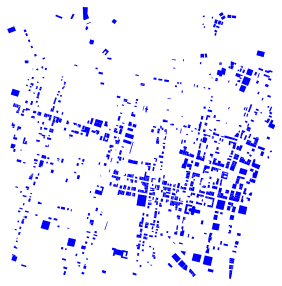

In [3]:
# Specify the name that is used to seach for the data
path = str(place_adr)[0:5] + "_HD.tif"

# Fetch OSM street network from the address
buildings = ox.footprints_from_address(place_adr, distance=1000)
type(buildings)

# Plot the buildings
fig, ax = ox.plot_footprints(buildings, figsize=(5,5), color="Blue")

In [4]:
buildings.columns[0:100]
# buildings = buildings[buildings['area'].notnull()]
cols = ['area', 'building:levels','geometry']
buildings = buildings[cols]

In [5]:
#Reproject coordinates into the desired EPSG projection
buildings = buildings.to_crs(epsg = projj4_crs)
#Calculate area m2
buildings["CAREA"] = buildings['geometry'].area
#Heat demand 19.85 KWh/m2
buildings["CHD_KWH"] = buildings['CAREA']*19.85
buildings.head(2)

,area,building:levels,geometry,CAREA,CHD_KWH
35148141,NaN,1,"POLYGON ((623890.425 -242203.271, 623957.480 -...",5925.340682,117618.012545
35405075,NaN,NaN,"POLYGON ((624683.189 -242262.626, 624742.946 -...",3791.784867,75266.929603


In [6]:
#Create HD tif
def gpdf_to_raster(df,path):
    x_max = df.total_bounds[2] 
    x_min = df.total_bounds[0]
    y_max = df.total_bounds[3] 
    y_min = df.total_bounds[1]
    pixel_size = 100.00

    cols = int((x_max - x_min)/pixel_size)
    rows = int((y_max - y_min)/pixel_size)
    shape = cols, rows

    transform = rasterio.transform.from_bounds(*df['geometry'].total_bounds, *shape)

    with rasterio.open(path, 'w+', driver="GTiff", dtype=rasterio.float32, count=1,
                       width=shape[0], height=shape[1], transform=transform,
                         compress= "LZW", nodata= 0, crs= int(projj4_crs)) as out:

        out_arr = out.read(1)
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(df.geometry, df.CHD_KWH))
        burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, all_touched=True, transform=out.transform)
        out.write_band(1, burned)
        
gpdf_to_raster(buildings, path)

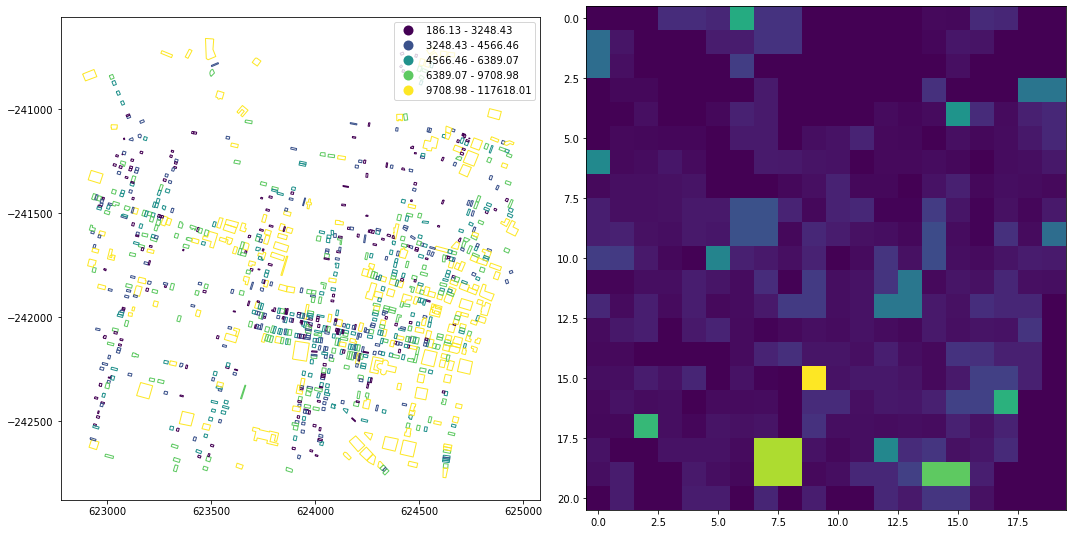

In [7]:
# Make subplots that are next to each other 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10)) 
buildings.plot(ax = axes[0], column='CHD_KWH',
        scheme = 'Quantiles' , edgecolor="purple", legend=True, categorical=False, facecolor="None")
plt.imshow(rasterio.open(path).read(1))
plt.tight_layout()

In [8]:
ar = rasterio.open(path)
print(ar.profile)
print(ar.crs.linear_units) #IMPORTANT TO GO TO THE NEXT PYTHON SCRIPT IT HAS TO BE IN METRE

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 20, 'height': 21, 'count': 1, 'crs': CRS.from_epsg(24817), 'transform': Affine(104.73891153438016, 0.0, 622881.5905792257,
       0.0, -100.53286871552007, -240662.45852251246), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
metre


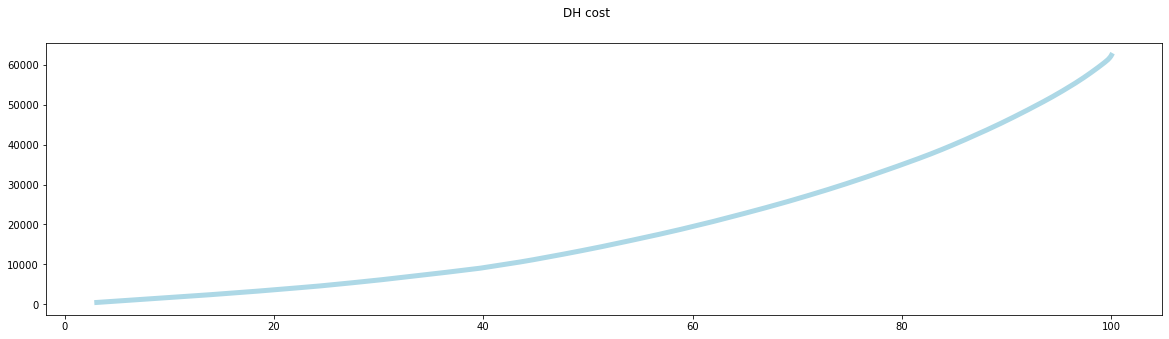

In [9]:
#Calculate district heating costs
def get_cellarea(tif):
    with rasterio.open(tif) as src:
        xcell = src.profile['transform'][0]
        ycell = - src.profile['transform'][4]
        cellarea = xcell*ycell
    return cellarea

def tif_to_XYZ_CSV(path, xyz_path, csv_path):
    ds = gdal.Open(path)
    translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-of xyz -co ADD_HEADER_LINE=YES -co COLUMN_SEPARATOR=,"))
    gdal.Translate(xyz_path, ds, options=translate_options)
    os.rename(xyz_path, csv_path)
    ds = None
    
def calculate_DH_csv (csv, n_csv):
    data = pd.read_csv(csv)
    data.rename(columns={'Z':'HD_MWh_yr'}, inplace = True)
    data = data[data['HD_MWh_yr']>0]
    cellarea = get_cellarea(path)
    #Calculate fields
    data['HDD_GJ_ha'] = (3.6 * data.HD_MWh_yr) / (cellarea / 10000)
    data.sort_values('HD_MWh_yr', ascending=False, inplace=True)
    data['Cost_EUR_GJ'] = 4924.8 * (data.HDD_GJ_ha )**(-0.645)
    data['Cost_EUR'] = data.Cost_EUR_GJ * (data.HD_MWh_yr * 3.6)
    data['DD_P_%'] = (data.HD_MWh_yr / (data['HD_MWh_yr'].sum())*100)
    data['D_ACC_%'] = data['DD_P_%'].cumsum()
    data['C_ACC_tEUR'] = data['Cost_EUR'].cumsum()/1000
    #Format
    pd.options.display.float_format = '{:.3f}'.format
    
    #Plot 
    fig, lns = plt.subplots(figsize=(20, 5))
    lns.plot(data['D_ACC_%'],data['C_ACC_tEUR'],label='DH Cost Curve', color='lightblue', linewidth=5)
    plt.suptitle('DH cost')
    cursor = Cursor(lns, horizOn=True, vertOn=True, color = 'red', linewidth = 5.0)
    def onclick(event):
        x1, y1 = event.xdata, event.ydata
        print(x1,y1)
        
    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    
    #Export as csv
    data.to_csv(n_csv, index = True)
    return data[-5:]

#Tif to txt
xyz_path = str(place_adr)[0:5] + '.xyz'
csv_path = str(place_adr)[0:5] + '.csv'
tif_to_XYZ_CSV(path, xyz_path, csv_path)

#DH calculations in CSV based on raster band 1
ncsv_path = str(place_adr)[0:5] + 'CSV.csv'
calculate_DH_csv(csv_path, ncsv_path)

#We have CSV containing only the pixels having values and all calculated fields and we delete the temp files
os.remove(csv_path)